# Movie Recommendation System Experiment 2

During the first year of Covid-19, I watched tons of movies and ended up bored with normal recommendation systems.
After all, there's only so many times you can re-watch all the Harry Potter saga or Guy Richie's filmography.
On top of that, Hollywood seems to be fixated with superhero movies or biopic, which get **very boring** very soon.

So I decided to try some simple ideas out, without even looking at a single recommender system paper.

## The Idea

Pretty standard _"find other users like me"_ but with some tweaks.

## Preparing the data

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as SS
import sklearn.metrics.pairwise
import scipy as sp
import scipy

In [2]:
# Config
MIN_RATINGS = 3

In [3]:
# Load my IMDB ratings
mine = pd.read_csv(
    './imdb-ratings.csv',
    delimiter=',',
    header=0,
    encoding='latin1',
)
mine['movie_id'] = mine['Const'].str.slice(2).astype(int)
mine.head()

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,movie_id
0,tt0100150,8,2013-08-04,Miller's Crossing,https://www.imdb.com/title/tt0100150/,movie,7.7,115.0,1990,"Crime, Drama, Thriller",127180,1990-09-21,"Joel Coen, Ethan Coen",100150
1,tt1001526,6,2014-01-25,Megamind,https://www.imdb.com/title/tt1001526/,movie,7.2,95.0,2010,"Animation, Action, Comedy, Family, Sci-Fi",232276,2010-10-28,Tom McGrath,1001526
2,tt1003034,6,2021-03-08,Perrier's Bounty,https://www.imdb.com/title/tt1003034/,movie,6.4,88.0,2009,"Action, Comedy, Crime, Drama, Romance, Thriller",6505,2009-09-11,Ian Fitzgibbon,1003034
3,tt10048342,8,2020-12-28,The Queen's Gambit,https://www.imdb.com/title/tt10048342/,tvMiniSeries,8.6,395.0,2020,Drama,301894,2020-10-23,NaN,10048342
4,tt0101410,6,2016-05-09,Barton Fink,https://www.imdb.com/title/tt0101410/,movie,7.7,116.0,1991,"Comedy, Drama, Thriller",114495,1991-05-18,"Joel Coen, Ethan Coen",101410


In [4]:
# Load twitter movie reviews
# (See: https://github.com/sidooms/MovieTweetings)
movies = pd.read_csv(
    './data/movie-tweetings/movies.dat',
    header=0,
    delimiter='::',
    names=['movie_id', 'title', 'genres'],
    dtype={
        'movie_id': int,
        'title': str,
        'genres': str,
    },
    engine='python',
)
movies.head()

,movie_id,title,genres
0,10,La sortie des usines Lumière (1895),Documentary|Short
1,12,The Arrival of a Train (1896),Documentary|Short
2,25,The Oxford and Cambridge University Boat Race ...,NaN
3,91,Le manoir du diable (1896),Short|Horror
4,131,Une nuit terrible (1896),Short|Comedy|Horror


<AxesSubplot:xlabel='std_rating', ylabel='Count'>

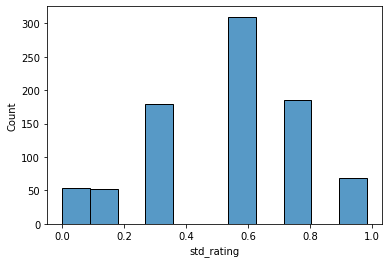

In [5]:
# Normalize my own ratings
prep_mine = mine.copy()
prep_mine['std_rating'] = \
    (prep_mine['Your Rating'] - prep_mine['Your Rating'].mean()) \
    / prep_mine['Your Rating'].std()

# Random tweak 1: turn the gaussian into a uniform random variable
# Note: IMDB ratings are coarse-grained, so it's kinda impossible to do that properly
#       (e.g.: I give a lot of 7's)
prep_mine['std_rating'] = (scipy.special.erf(prep_mine['std_rating'] / np.sqrt(2)) + 1) / 2

# View the resulting distribution
sns.histplot(prep_mine['std_rating'])

In [6]:
# Load twitter users' movie ratings
rate = pd.read_csv(
    './data/movie-tweetings/ratings.dat',
    names=['user_id', 'movie_id', 'rating', 'rating_timestamp'],
    delimiter='::',
    header=None,
    encoding='latin1',
    dtype={
        'user_id': int,
        'movie_id': int,
        'rating_id': int,
        'rating_timestamp': int,
    },
    engine='python',
)

# Start from 0
rate.user_id -= 1

rate.head()

,user_id,movie_id,rating,rating_timestamp
0,0,114508,8,1381006850
1,1,499549,9,1376753198
2,1,1305591,8,1376742507
3,1,1428538,1,1371307089
4,2,75314,1,1595468524


In [7]:
# Cleanup: remove users with less than MIN_RATINGS unique rating values
user_nunique = rate[['user_id', 'rating']].groupby('user_id').nunique()
blacklist = user_nunique[user_nunique['rating'] <= MIN_RATINGS].reset_index()
old_shape = rate.shape
rate = rate[~rate['user_id'].isin(blacklist['user_id'])]
old_shape, rate.shape

((901964, 4), (789859, 4))

<AxesSubplot:xlabel='rating', ylabel='Count'>

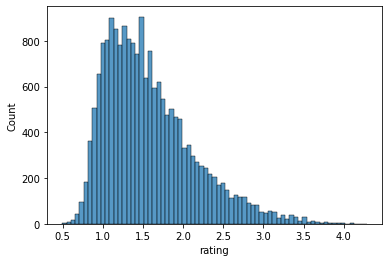

In [8]:
# Let's take a look at users' rating std deviation distribution
user_rating_std = rate.groupby('user_id')['rating'].std(ddof=0)
sns.histplot(user_rating_std)

In [9]:
# Get mean/std to normalize the users' ratings
scaler = pd.DataFrame()
scaler['user_avg'] = rate.groupby('user_id')['rating'].mean()
scaler['user_std'] = rate.groupby('user_id')['rating'].std(ddof=0)

# Normalize
prep_rate = rate.join(scaler, on='user_id')
prep_rate['std_rating'] = (prep_rate['rating'] - prep_rate['user_avg']) / prep_rate['user_std']
prep_rate['std_rating'] = (scipy.special.erf(prep_rate['std_rating'] / np.sqrt(2)) + 1) / 2
#prep_rate['std_rating'].fillna(0, inplace=True)
#prep_rate.loc[prep_rate['std_rating'] < 0]['std_rating'] = 0
prep_rate.head()

,user_id,movie_id,rating,rating_timestamp,user_avg,user_std,std_rating
4,2,75314,1,1595468524,7.047619,2.192546,0.002905
5,2,102926,9,1590148016,7.047619,2.192546,0.813391
6,2,114369,10,1597555347,7.047619,2.192546,0.910938
7,2,118715,8,1596006798,7.047619,2.192546,0.667991
8,2,120737,8,1599306720,7.047619,2.192546,0.667991


<AxesSubplot:xlabel='std_rating', ylabel='Count'>

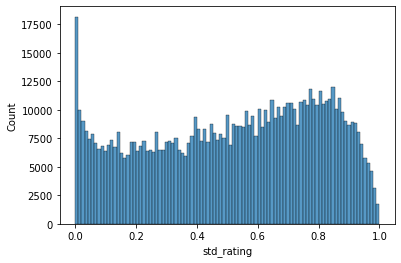

In [10]:
# Look at the normalized ratings' distribution, globally (uniform, in theory, but unlikely)
sns.histplot(prep_rate['std_rating'])

In [11]:
# Create the rating matrix
# `offset` is basically the default rating for unrated movies
# Apparently 0.5 works best-ish
#offset = 0
offset = 0.5
rmat = SS.coo_matrix((prep_rate.std_rating - offset, (prep_rate.user_id, prep_rate.movie_id)))
rmat = rmat.tocsc()
rmat

<70418x14404281 sparse matrix of type '<class 'numpy.float64'>'
	with 789859 stored elements in Compressed Sparse Column format>

<AxesSubplot:ylabel='Count'>

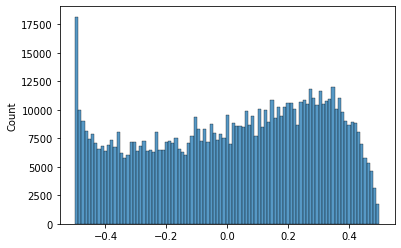

In [12]:
# Check distribution again after offsetting, just to be sure
sns.histplot(np.ndarray.flatten(rmat.data))

In [13]:
# Make the query vector R_[1, MOVIES] using my own ratings
query = np.zeros((1, rmat.shape[1]))
query[0, prep_mine['movie_id']] = prep_mine['std_rating'] - offset
query

array([[0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# Find cosine similarity between me and other people, then normalize between in [0, 1]
score = sklearn.metrics.pairwise.cosine_similarity(rmat, query)
score = score[:, 0]
score = score - score.min()
score /= score.max()
score.shape

(70418,)

In [15]:
# Remove movies I already rated
out_mat = rmat.copy().tolil()
out_mat[:, prep_mine['movie_id']] = 0
out_mat = out_mat.tocsc()

In [16]:
# Similarity vs popularity heuristics
score = score ** 0.5

In [17]:
# Weight the other users' ratings by the similarity score
score = score.reshape(-1, 1)
out = out_mat.multiply(score)
out.eliminate_zeros()

<AxesSubplot:ylabel='Count'>

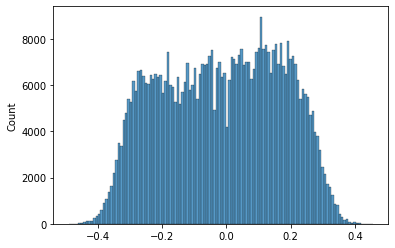

In [18]:
sns.histplot(out.data)

<AxesSubplot:ylabel='Count'>

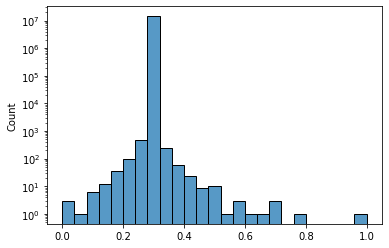

In [19]:
# Normalize the suggestions in [0, 1]
movie_scores = np.array(out.sum(axis=0))[0]
movie_scores = movie_scores - movie_scores.min()
movie_scores /= movie_scores.max()
movie_indexes = movie_scores.argsort()[::-1]
movie_scores = movie_scores[movie_indexes]

# See what's going on
sns.histplot(movie_scores, log_scale=(False, True))

In [20]:
# Make the final recommendation dataframe
rec = pd.DataFrame()
rec['movie_id'] = movie_indexes
rec['score'] = movie_scores
rec = rec.join(on='movie_id', other=movies.set_index('movie_id'))

In [21]:
# Best matches
rec.head(20)

,movie_id,score,title,genres
0,1454468,1.000000,Gravity (2013),Drama|Sci-Fi|Thriller
1,1663202,0.784491,The Revenant (2015),Action|Adventure|Biography|Drama|Western
2,3170832,0.709449,Room (2015),Drama|Thriller
3,3783958,0.703927,La La Land (2016),Comedy|Drama|Music|Musical|Romance
4,1798709,0.681771,Her (2013),Drama|Romance|Sci-Fi
5,1170358,0.659766,The Hobbit: The Desolation of Smaug (2013),Adventure|Fantasy
6,2980516,0.600484,The Theory of Everything (2014),Biography|Drama|Romance
7,2380307,0.582097,Coco (2017),Animation|Adventure|Comedy|Family|Fantasy|Musi...
8,2948356,0.565030,Zootopia (2016),Animation|Adventure|Comedy|Crime|Family|Mystery
9,3741834,0.560316,Lion (2016),Biography|Drama


In [22]:
# Worst matches
# These look more accurate than the good ones lol
rec.tail(10)

,movie_id,score,title,genres
14404271,1502712,0.117979,Fantastic Four (2015),Action|Adventure|Drama|Sci-Fi
14404272,1606378,0.114418,A Good Day to Die Hard (2013),Action|Thriller
14404273,2109248,0.099481,Transformers: Age of Extinction (2014),Action|Adventure|Sci-Fi
14404274,831387,0.094559,Godzilla (2014),Action|Adventure|Sci-Fi|Thriller
14404275,2322441,0.093987,50 tinten grijs (2015),Drama|Romance|Thriller
14404276,2872732,0.080496,Lucy (2014),Action|Sci-Fi|Thriller
14404277,1959490,0.053464,Noah (2014),Action|Adventure|Drama
14404278,2184339,0.033905,The Purge (2013),Horror|Thriller
14404279,1815862,0.016003,After Earth (2013),Action|Adventure|Sci-Fi
14404280,1951261,0.000000,The Hangover Part III (2013),Adventure|Comedy|Crime


In [23]:
# Print more suggestions for debug purposes
for i, row in rec[:100].iterrows():
    _, score, title, genres = row
    print(f'{score:0.4f} {title:50s} {genres}')

1.0000 Gravity (2013)                                     Drama|Sci-Fi|Thriller
0.7845 The Revenant (2015)                                Action|Adventure|Biography|Drama|Western
0.7094 Room (2015)                                        Drama|Thriller
0.7039 La La Land (2016)                                  Comedy|Drama|Music|Musical|Romance
0.6818 Her (2013)                                         Drama|Romance|Sci-Fi
0.6598 The Hobbit: The Desolation of Smaug (2013)         Adventure|Fantasy
0.6005 The Theory of Everything (2014)                    Biography|Drama|Romance
0.5821 Coco (2017)                                        Animation|Adventure|Comedy|Family|Fantasy|Music|Mystery
0.5650 Zootopia (2016)                                    Animation|Adventure|Comedy|Crime|Family|Mystery
0.5603 Lion (2016)                                        Biography|Drama
0.5379 Dawn of the Planet of the Apes (2014)              Action|Adventure|Drama|Sci-Fi
0.5192 The Fault in Our Stars (2014)

Apparently, I should really watch Gravity (:

Cheers,

_babush_